In [1]:
#
#* 데이터 경로 설정
root_dir = !pwd
root_dir = root_dir[0]
# !mkdir -p data_demo
# %cd data_demo
# !gdown 1wjuiVcO92Rqer5gLk-X7hINfe4PCMQmu
# !pip install tqdm
# !unzip -o 5LpN3gDmAk7_1.zip | tqdm --desc extracted --unit files --unit_scale --total `unzip -l 5LpN3gDmAk7_1.zip | tail -n 1 | xargs echo -n | cut -d' ' -f2` > /dev/null
# %cd ..
import os
#data_dir = "/home/hong/capstone/vlmaps/data_custom"
scene_id = "apartment_0_1"
data_dir = os.path.join(root_dir, "Data/habitat_sim/vlmaps_dataset", scene_id) #vlmaps_dataset
version = "gt"
#
#* 갖고있는 depth, rgb 이미지를 이용해 비디오로 시각화해주는 작업
#* 단순 시각화용일 뿐이며, VLMaps 제작이나 이후 작업에 사용되지는 않음
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth


In [2]:
#
#* setup VLMaps parameters
# @markdown meters per cell size
cs = 0.025 # @param {type: "number"} #* 셀 크기 당 미터 단위
# @markdown map resolution (gs x gs)
gs = 2000 # @param {type: "integer"} #* 맵의 해상도 (그리드 수 _ 정수 단위)
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"} #* 카메라 높이 (바닥에 있는 점을 필터링하는 데 사용)
# @markdown depth pixels subsample rate
depth_sample_rate = 10 # @param {type: "integer"} #* depth 정보의 픽셀 sampling rate
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"} #* 데이터 경로

In [3]:
#
#* 갖고있는 depth, rgb 이미지를 이용해 비디오로 시각화해주는 작업
#* 단순 시각화용일 뿐이며, VLMaps 제작이나 이후 작업에 사용되지는 않음
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth



def get_fast_video_writer(video_file: str, fps: int = 60):
    if (
        "google.colab" in sys.modules
        and os.path.splitext(video_file)[-1] == ".mp4"
        and os.environ.get("IMAGEIO_FFMPEG_EXE") == "/usr/bin/ffmpeg"
    ):
        # USE GPU Accelerated Hardware Encoding
        writer = imageio.get_writer(
            video_file,
            fps=fps,
            codec=codec,
            mode="I",
            bitrate="1000k",
            format="FFMPEG",
            ffmpeg_log_level="info",
            quality=10,
            output_params=["-minrate", "500k", "-maxrate", "5000k"],
        )
    else:
        # Use software encoding
        writer = imageio.get_writer(video_file, fps=fps)
    return writer

def create_video(data_dir: str, output_dir: str, fps: int = 30):
    
    rgb_dir = os.path.join(data_dir, "rgb")
    depth_dir = os.path.join(data_dir, "depth")
    rgb_out_path = os.path.join(output_dir, "rgb.mp4")
    depth_out_path = os.path.join(output_dir, "depth.mp4")
    rgb_writer = get_fast_video_writer(rgb_out_path, fps=fps)
    depth_writer = get_fast_video_writer(depth_out_path, fps=fps)

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pbar = tqdm.tqdm(total=len(rgb_list), position=0, leave=True)
    for i, (rgb_path, depth_path) in enumerate(zip(rgb_list, depth_list)):
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        depth = load_depth(depth_path)
        depth_vis = (depth / 10 * 255).astype(np.uint8)

        depth_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)

        rgb_writer.append_data(rgb)
        depth_writer.append_data(depth_color)
        pbar.update(1)
    rgb_writer.close()
    depth_writer.close()

def show_video(video_path, video_width = 1080):
   
    video_file = open(video_path, "r+b").read()
  
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>""")

def show_videos(video_paths, video_width = 1080):
    html = ""
    for video_path in video_paths:
        video_file = open(video_path, "r+b").read()
      
        video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
        html += f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>
                 """
    return HTML(html)



In [4]:
# create_video(data_dir, data_dir, fps=30)

In [5]:
# show rgb and depth
# show_videos([data_dir + "/rgb.mp4", data_dir + "/depth.mp4"])


In [6]:
# @title Helper functions for VLMap Creation
#* VLMap 제작 함수!

import os
import math
import json

import numpy as np
import cv2
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import clip

from utils.mapping_utils import load_pose, save_map, depth2pc, transform_pc, get_sim_cam_mat, pos2grid_id, project_point, load_semantic_npy, cvt_obj_id_2_cls_id, load_obj2cls_dict

"""
& load_pose : pose.txt 파일 ㅌ하나를 읽어서 7개의 숫자 중 앞쪽 3개는 pos로, 뒤쪽 4개는 rot 정보로 읽어서 (pos,rot)를 반환
& save_map : npy 배열 형태의 color_top_down, grid, weight, obstacles 저장
& depth2pc : depth 정보를 이용해 point cloud 생성 (3xN 사이즈의 array 반환)
    ! 저 utils안에 depth2pc_aithor, depth2pc_real_world 등 두 개의 함수 추가로 존재, 이걸로도 가능한지 확인 필요, 성능 확인 필요
    ? 관련 url
        https://medium.com/@ramazanilkera2/rgbd-to-3d-point-cloud-223b0a6f46db
        https://www.google.com/search?q=depth+to+point+cloud&oq=depth+to+point+cloud&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIGCAEQLhhA0gEJMTQ1ODZqMGo5qAIAsAIA&sourceid=chrome&ie=UTF-8
        https://medium.com/yodayoda/from-depth-map-to-point-cloud-7473721d3f
        https://github.com/HarendraKumarSingh/stereo-images-to-3D-model-generation/blob/master/depth-map-to-3D-point-cloud.ipynb
& transform_pc : point cloud를 robot coo.에서 global coo.으로 변환해주는 함수?
& get_sim_cam_mat : point cloud의 projection matrix에서 3x3 부분을 반환해주는 함수
& pos2grid_id : 좌표계를 grid기반으로 바꿔주는 함수로, 맵의 크기를 반으로 나누어 중심에서부터 시작해 좌표값을 한 grid당 거리로 나누어 중심으로부터 떨어진 거리를 구해 더하여 grid 기반의 좌표, 즉 id로 바꿈
& project_point : p local을 rgb나 pix_feat의 투영행렬을 이용해 각각의 차원으로 투영해주는 함수
"""

from lseg.modules.models.lseg_net import LSegEncNet #* LSeg model
from lseg.additional_utils.models import resize_image, pad_image, crop_image

"""
& resize_image : 
& pad_image :
& crop_image :
"""



#* 이 함수를 사용해 VLMaps 제작!
def create_lseg_map_batch(img_save_dir, camera_height, cs=0.05, gs=1000, depth_sample_rate=100):
    mask_version = "lseg" # 0, 1

    crop_size = 480 # 480
    base_size = 520 # 520
    lang = "door,chair,ground,ceiling,other"
    labels = lang.split(",")

    # loading models
    #^ 이 섹션의 목표는 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(device)
    clip_version = "ViT-B/32" #! clip ckpt 이름!!!! https://huggingface.co/openai/clip-vit-base-patch32/tree/main 이거이거! / https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt 깃헙! /https://github.com/openai/CLIP/blob/main/clip/clip.py 여기서 확인 가능! / https://huggingface.co/docs/transformers/model_doc/clip
                                #* https://velog.io/@dongdori/CLIP2021-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0 간단 설명
            #^ /home/hong/capstone/vlmaps_demo/vlmaps/lseg/modules/models/lseg_net.py 여기서 LSEgencNet 봐보면 ckpt별로 다르게 out_c가 지정되어있는 것을 확인할 수 있으며, 우리의 모델의 경우 512라는 것을 알 수 있음!
            #^ clip version은 따로 다운 받은게 아니라, clip이라는 라이브러리에서 제공하는 것을 사용!
    clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                    'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
    print("Loading CLIP model...")
    clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
    clip_model.to(device).eval()
    lang_token = clip.tokenize(labels)
    lang_token = lang_token.to(device)
    with torch.no_grad():
        text_feats = clip_model.encode_text(lang_token)
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
    text_feats = text_feats.cpu().numpy()
    model = LSegEncNet(lang, arch_option=0, #* 그냥 lseg 파라미터자너
                        block_depth=0,
                        activation='lrelu',
                        crop_size=crop_size)
    model_state_dict = model.state_dict()
    pretrained_state_dict = torch.load("/nvme0n1/hong/VLMAPS/InstanceSeemMap/lseg/ckpt/demo_e200.ckpt")
    pretrained_state_dict = {k.lstrip('net.'): v for k, v in pretrained_state_dict['state_dict'].items()}
    model_state_dict.update(pretrained_state_dict)
    model.load_state_dict(pretrained_state_dict) #* 그냥 lseg 모델 정의한거고

    model.eval()
    model = model.cuda()

    norm_mean= [0.5, 0.5, 0.5]
    norm_std = [0.5, 0.5, 0.5]
    padding = [0.0] * 3
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

    print(f"loading scene {img_save_dir}")
    rgb_dir = os.path.join(img_save_dir, "rgb")
    depth_dir = os.path.join(img_save_dir, "depth")
    pose_dir = os.path.join(img_save_dir, "pose")
    semantic_dir = os.path.join(img_save_dir, "semantic")
    semantic_info_path = os.path.join(data_dir, "semantic_info.json")
    with open(semantic_info_path, "r", encoding="utf-8") as f:
        semantic_info = json.load(f)
    semantic_info = {int(key):val for key, val in semantic_info.items()}
    semantic_info_sorted = dict(sorted(semantic_info.items(), key = lambda item : int(item[0])))
    semantic_info_list = []
    semantic_info_new_index = {}
    for i, (key, val) in enumerate(semantic_info_sorted.items()):
        semantic_info_list.append(val)
        semantic_info_new_index[key] = i
    # obj2cls_path = os.path.join(img_save_dir, "obj2cls_dict.txt")

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    semantic_list = sorted(os.listdir(semantic_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pose_list = [os.path.join(pose_dir, x) for x in pose_list]
    semantic_list = [os.path.join(semantic_dir, x) for x in semantic_list]


    #^ output은 color_top_down, grid, weight, obstacles로 저장됨
    #! https://huggingface.co/ai-forever/ruclip-vit-base-patch32-384
    map_save_dir = os.path.join(img_save_dir, "map")
    os.makedirs(map_save_dir, exist_ok=True)
    color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{mask_version}.npy") #* 말 그대로 위에서 내려다본 rgb맵
    gt_save_path = os.path.join(map_save_dir, f"grid_{mask_version}_gt.npy")
    grid_save_path = os.path.join(map_save_dir, f"grid_lseg_{mask_version}.npy") #* 각 그리드에 semantic segmentation결과 class별 확률 정보를 저장해둔 맵
    weight_save_path = os.path.join(map_save_dir, f"weight_lseg_{mask_version}.npy") #* semantic segmentation이 여러 이미지에 이루어지니 겹쳐지는 그리드 발생, 각 그리드 별로 몇번 겹쳐졌는지 저장한 맵
                                                                                    #* 이는, semantic 대표값을 여러번의 segmentation의 평균으로 했기에 사용됨 (각 segmentation class별 확률의 평균)
    obstacles_save_path = os.path.join(map_save_dir, f"obstacles_{mask_version}.npy") #* 말 그대로 0,1로 이루어진 obstacle맵
    semantic_info_save_path = os.path.join(map_save_dir, f"semantic_info_{mask_version}.json")
    # obj2cls = load_obj2cls_dict(obj2cls_path)

    # initialize a grid with zero position at the center
    color_top_down_height = (camera_height + 1) * np.ones((gs, gs), dtype=np.float32) #* color_top_down에서 height를 비교해 더 낮은 height를 가질 때의 rgb값을 저장하기 위해 사용됨
    color_top_down = np.zeros((gs, gs, 3), dtype=np.uint8)
    gt = np.zeros((gs, gs), dtype=np.int32)
    grid = np.zeros((gs, gs, clip_feat_dim), dtype=np.float32)
    obstacles = np.ones((gs, gs), dtype=np.uint8) #* gs*gs의 정사각형 모양 맵이네 뭐지?왜? 아 그냥 크게 여유있게 gs를 잡아뒀으니깐 (그 맵 나온거 보면 까맣게 비어있는 곳 넓자너)
    weight = np.zeros((gs, gs), dtype=float)

    # save_map(color_top_down_save_path, color_top_down)
    save_map(gt_save_path, gt)
    # save_map(grid_save_path, grid)
    # save_map(weight_save_path, weight)
    save_map(obstacles_save_path, obstacles)

    tf_list = []
    data_iter = zip(rgb_list, depth_list, pose_list, semantic_list)
    pbar = tqdm(total=len(rgb_list))
    # load all images and depths and poses










    """
    *데이터 차원!!
    *depth : (720,1080)
    *rgb : (720, 1080, 3)
    *semantic segmentation 결과 : (1,512,347,520)
    """

    n_test = 0

    #* 여기서부터 시작!!! (앞은 경로 설정이랑 cuda, 모델 로드 등)
    for data_sample in data_iter:
        rgb_path, depth_path, pose_path, semantic_path = data_sample
        
        # read rgb
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        # read pose
        pos, rot = load_pose(pose_path)  # z backward, y upward, x to the right #* 이걸 통해 나온 ros는 쿼터니안이 회전행렬 형태로 변환된 것
        rot_ro_cam = np.eye(3) 
        rot_ro_cam[1, 1] = -1
        rot_ro_cam[2, 2] = -1 #* [[1,0,0],[0,-1,0],[0,0,-1]] -> y, z축 각각 반전!
        rot = rot @ rot_ro_cam #! rot 뛰에 변환행렬 곱했네 뭐겠어 local coo.을 global coo.으로 바꾸는 거겠지
        aa=np.array([[1,0,0],[0,0,1],[0,-1,0]])
        # rot = rot@aa #!#!#!#!#!##!!
        pos[1] += camera_height #! 기존 pos값은 이미지에서의 높이이니, 그 아래의 카메라 높이만큼 더해줘야됨
        """
        In the code, we use the default robot coordinate frame that Habitat-Sim uses: z backward, x right, y up. So the position of the camera relative to the robot frame should be camera_height above the robot frame (in y direction), so the last line of the code is pos[1] += camera_height       
        """
        pose = np.eye(4)
        pose[:3, :3] = rot
        """
        ? ? ? 0
        ? ? ? 0
        ? ? ? 0
        0 0 0 1
        """
        pose[:3, 3] = pos.reshape(-1) #* 행벡터를 열벡터로 치환해 대입 ->rotation matrix, translation matrix 모두 포함된 transformation matrix
        """
        R T 
        0 1
        """

        tf_list.append(pose) #* 아마 각 pose마다의 변환행렬 (변환행렬 변수명이 pose임)을 리스트 형태로 저장하려는듯
        if len(tf_list) == 1:
            init_tf_inv = np.linalg.inv(tf_list[0])  #* 첫번째인 경우엔 전의 기록이 없으니 역행렬을 구해줌

        tf = init_tf_inv @ pose #* robot coo.을 global coo.으로 변형하기 위한 matrix
                                #! 첫번째의 경우 pose와 pose의 역행렬이 곱해지니 첫번째 tf는 단위행렬이 됨
                                #! 봐봐 생각을 해봐 첫번째의 경우엔 이동을 안했잖아 그러니깐 그냥 global = local이라고 생각하고 하면 되니깐 변환행렬도 단위 행렬인거지
                                #! 반면에 그 다음부터는 이전의 이동이 계속 누적되었으니 그걸 감안한 변환행렬을 사용해야될 것이고

        # read depth
        depth = load_depth(depth_path)
        # read semantic
        semantic = load_semantic_npy(semantic_path)
        # semantic = cvt_obj_id_2_cls_id(semantic, obj2cls) #! here
        #! LSeg 모델을 사용해 semantic segmentation 진행, 그 확률 map을 반환해 pix_feats에 저장
        #* pix_feats의 차원 : (1, 512, 347, 520) 흠.... (배치크기, 픽셀 임베딩 벡터의 차원, height, width)
            #! rgb랑 depth는 크기가 동일한 것을 보니 얘는 semantic segmentation 과정에서 pad, trim 등의 과정에 영향을 받은 듯
        # pix_feats = get_lseg_feat(model, rgb, labels, transform, crop_size, base_size, norm_mean, norm_std)





        # transform all points to the global frame
        #* pc획득하고 다운샘플링 진행 - sampling rate은 위쪽 셀에서 수정 가능
        """
            ! 여기서 shuffle이 들어가도 상관없는 이유
            * -> mask랑 같이 pc도 같이 shuffle되고, pc 안에는 x,y,z정보가 이미 담겨있음
            * -> 따라서 벡터 요소 순서가 바뀌어도 위치 정보는 벡터 순서가 아닌 value로 담고 있기에 바뀌어도 상과 없다!

            ! 그렇다면, shuffle하는 이유와 depth의 down sampling을 진행하는 이유는 무엇인가
            * 노션에 올린 이미지처럼 특정 대각선이나 특정 방향의 데이터를 추출하게 되어 일정한 경향성을 띌 수 있음
            * 따라서 특정한 패턴이 발생하지 않도록 무작위성을 넣어 뽑도록 함

            * pc는 결국 (3,777600)에서 (3,7776)으로 바뀜
            !! 셔플 마스크에 저장되어 있는 것은 랜덤하게 바뀐 인덱스 정보
            !! 마스크에 저장되어 있는 것은 T/F의 정보!
            !! 어차피 pc랑 mask 둘 다 shuffle_mask를 통해 랜덤하게 바뀌고 필터링되었으므로 pc랑 mask 서로의 인덱스는 일치!!!
            !! 마스크 써서 z값이 0.1보다 큰 놈들만 있게 필터링하면 최종적으로 크기가 (3,4377)로 바뀜!
            * (3,777600) -> (3,7776) -> (3,4377)
        """
        pc, mask = depth2pc(depth) #* 그 이슈에 여기 왜 셔플하는지 물어보는 내용 있음 https://github.com/vlmaps/vlmaps/issues/37 (실사용에선 depth2pc_real_world사용해야됨!)
        shuffle_mask = np.arange(pc.shape[1])
        np.random.shuffle(shuffle_mask) #! 왜???셔플???
        shuffle_mask = shuffle_mask[::depth_sample_rate] #! depth 정보를 다 가져가지 않고 sample rate만큼만 가져가네 뭐지
        mask = mask[shuffle_mask]
        pc = pc[:, shuffle_mask] #* 단순 필터링 과정, 인덱싱이지 뒤쪽에 벡터를 추가해준다는게 아님!
        pc = pc[:, mask] #* 이번에는 로봇으로부터 0.1 이상 떨어져있는 가에 대한 필터링 진행
        pc_global = transform_pc(pc, tf) #* 로봇 coo.에서 global coo.으로 변환!





        #* 여기는 그 결과물 map으로 저장하는 부분!
        #^ 중요!!!!!!!!!!!!!!!!!!! 여기 이거 그 get_sim_cam_mat_with_fov로 구하는게 더 정확하긴해서 나중에 갈아낄까봐
        #^ 그그 point cloud issue에 나와있음
        #^ 이거 뭐내면 그 point cloud projection matrix 최종형 4by4의 3by3부분임
        #^ 이전에는 depth 기준이었고 이번에는 rgb, pix_feats 기준으로 projection matrix를 구하는 것
        """
        *이전 셀에서 정의했던 파라미터들
        cs = 0.05 #* 셀 크기 당 미터 단위
        gs = 1000 #* 맵의 해상도 (그리드 수 _ 정수 단위)
        camera_height = 1.5 #* 카메라 높이 (바닥에 있는 점을 필터링하는 데 사용)
        depth_sample_rate = 100 #* depth 정보의 픽셀 sampling rate
        data_dir = data_dir #* 데이터 경로
        """
        #! fov가 음 fixed focus(그 중에서도 ov9782)면 depth랑 동일하게 89.5도라 get_sim_cam_mat_with_fov로 구해도 똑같아서 상관없는데 아니라면 78도, 82도로 차이가 존재함 흠...
        #* rgb랑 pix 따로 구하는게 depth이미랑 사이즈가 안맞을 수 있으니 각자의 투영행렬을 구해서 각각 적용시켜주면 해당 pose에서의 알맞은 depth, rgb, pix값이 적용되기 때문!
        rgb_cam_mat = get_sim_cam_mat(rgb.shape[0], rgb.shape[1]) #* rgb 크기인 720,1080이 들어감
        # feat_cam_mat = get_sim_cam_mat(pix_feats.shape[2], pix_feats.shape[3]) #* pix_feats의 이미지 크기인 347,520이 들어감
        # project all point cloud onto the ground



        for i, (p, p_local) in enumerate(zip(pc_global.T, pc.T)):
            #* 기존 z취급하던 애를 y로 취급함 -> 이제부터는 맵 저장 관련된 작업인데, 맵은 top_down방식으로 그려지니깐 맵의 그리드를 x,y로 표현하려고 z를 y로 바꿔 부름!
            x, y = pos2grid_id(gs, cs, p[0], p[2])

            #* ignore points projected to outside of the map and points that are 0.5 higher than the camera (could be from the ceiling)
            
            if x >= obstacles.shape[0] or y >= obstacles.shape[1] or x < 0 or y < 0 or p_local[1] < -0.5:   #* 이건 맵의 가로세로 길이보다 큰지 확인하는 것이고(obstacles는 앞에서 크기가 gs*gs로 충분히 크게 정의되었으니)
                                                                                                            #*음수가 나올 수 없지, 그리고 높이가 -0.5보다 커야되는 이유는 그 카메라 높이를 0.5로 잡아뒀으니 절대적으로는 0보다 커야되는 것이 됨
                continue #* 이 경우 해당 데이터는 날려버림!



            #^ 이건 rgb top down에 대한 projection, map 저장
            rgb_px, rgb_py, rgb_pz = project_point(rgb_cam_mat, p_local)
            #* 여기서 p_global 안쓰고 project_point에 projection행렬과 local좌표를 넣어 투영된 좌표를 따로 얻는 이유
                #* -> 아까 p_global은 depth 기준으로 구했었으니 이걸 사용하면 안맞음 -> 아까 그래서 rgb이미지가 depth이미지 크기랑 다를 수 있으니 Rgb를 위한 투영행렬을 구했잖음  그래서 Rgb에 맞는 투영 좌표 획득!
    
            #!#!#!#!#!#!#!#!
            rgb_v = rgb[rgb_py, rgb_px, :] #* 그래서 해당 pose에서의 rgb의 이미지 좌표를 획득했으니 넣어서 rgb값 3차원을 뽑아내고
            semantic_v = semantic[rgb_py, rgb_px] 
            if semantic_v == 0: 
                n_test += 1
                semantic_v = -1
            semantic_v = semantic_info_new_index[semantic_v]
            # if semantic_v == 40:
            #    semantic_v = -1
            # when the projected location is already assigned a color value before, overwrite if the current point has larger height
            if p_local[1] < color_top_down_height[y, x]: #* 이미 저장되어있는 경우 height를 비교해 더 낮은 height를 가질 때의 rgb값을 저장해둠!
                color_top_down[y, x] = rgb_v
                color_top_down_height[y, x] = p_local[1]
                gt[y,x] = semantic_v #* gt는 ground truth로, 결과 확인을 위해 정답지 같은 느낌인거지 그니깐 여기서 semantic의 결과가 잘 나왔는지 확인을 위해 저장하는 것




            # #^ 이건 pix_feats에 대한 projection, map 저장
            # # average the visual embeddings if multiple points are projected to the same grid cell
            # px, py, pz = project_point(feat_cam_mat, p_local) #* pix_feats 기준 projection
            # if not (px < 0 or py < 0 or px >= pix_feats.shape[3] or py >= pix_feats.shape[2]): #* 마찬가지로 맵 밖으로 벗어났는지 확인
            #     feat = pix_feats[0, :, py, px] #* 2번째의 차원은 semantic class의 차원이징 그니깐 이건 행벡터가 나오겠지
            #     #* weight는 맨처음에 0행렬로 정의되어있음, 보면 (y,x)가 겹칠 때마다 해당 좌표에서의 weight가 1씩 늘어나는 것을 알 수 있는데, 이는 그 여러번 겹치면 그 평균을 대표값으로 사용하기에 그 계산을 위해 저장되는 것
            #     grid[y, x] = (grid[y, x] * weight[y, x] + feat) / (weight[y, x] + 1)  #* 그래서 그리드맵에는 확률이 저장되니 겹쳐질 때마다 weight를 사용해 평균을 구하여 대푯값으로 넣어줌
            #     weight[y, x] += 1 #* 한번 겹쳐질 때마다 최신화 해주는 것
            

            #^ 이건 obstacle map
            #* build an obstacle map ignoring points on the floor (0 means occupied, 1 means free)
            #* 그러니깐 p_local값이 camera_height보다 크면, 해당 장애물은 부릉이 위에 있는거니깐 장애물에서 제외하겠다 이거네
            if p_local[1] > camera_height:
                continue
            obstacles[y, x] = 0
        pbar.update(1)


    print(gt.shape)
    print(n_test)
    # save_map(color_top_down_save_path, color_top_down)
    save_map(gt_save_path, gt)
    # save_map(grid_save_path, grid)
    # save_map(weight_save_path, weight)
    save_map(obstacles_save_path, obstacles)
    with open(semantic_info_save_path, "w", encoding="utf-8") as f:
        json.dump(semantic_info_list, f, ensure_ascii=False, indent=4)





#?#######################################################################################################################################################





#^ 49407 512



def get_lseg_feat(model: LSegEncNet, image: np.array, labels, transform, crop_size=480, \
                 base_size=520, norm_mean=[0.5, 0.5, 0.5], norm_std=[0.5, 0.5, 0.5]):
    vis_image = image.copy() 
    """
    * transform : torchvision.transforms.Compose로 정의된 transform 함수
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )
    ? 이미지 전처리 담당하는 함수!
    ? - 이미지 포맷을 torch.tensor로 변환
    ? - 이미지의 모든 채널(RGB)에 대해 평균과 표준편차를 0.5로 두고 normalize -> z-score normalization
                                                                    -> (x - mean) / std
                                                                    -> 원래는 rgb값의 범위가 0~255지만, pytorch 등의 많은 딥러닝 프레임워크에선 0~1의 부동소수점 값으로 바꿔 사용함
                                                                    -> 따라서 rgb값의 mean, std값인 0.5를 사용해 normalize!
                                                                    -> 따라서 normalize 결과는 -1 ~1 사이 범위를 가짐!!!
    """
    
    image = transform(image).unsqueeze(0).cuda() #* 아마 배치의 차원을 추가해준 듯 함 -> (배치, 채널, 높이, 너비)의 차원
    img = image[0].permute(1,2,0) #* 차원 순서의 재정렬 012 -> 120 -> img는 (높이, 너비, 채널)차원을 가짐
    img = img * 0.5 + 0.5 #* normalize 범위가 -1~1이었는데 이를 0~1로 바꾸기 위함!
    
    batch, _, h, w = image.size() #* 이미지의 채널 차원만 빼고 나머지 차원을 획득
    stride_rate = 2.0/3.0 #* stride rate는 2/3으로 설정 -> 정확도 향상을 위해 stride!
    stride = int(crop_size * stride_rate)

    #* 반올림을 위해 0.5를 더해줌 (int는 기본적으로 버림이라!) -> 이미지 비율을 유지하기 위해 반올림 사용
    #* h,w는 리사이징 전 맵의 크기, height, width는 리사이징 후 맵의 크기 -> 가로세로 비율 맞춰 바꿔주며, 반올림을 위해 0.5를 더해줌
    long_size = base_size
    if h > w:
        height = long_size
        width = int(1.0 * w * long_size / h + 0.5)
        short_size = width
    else:
        width = long_size
        height = int(1.0 * h * long_size / w + 0.5)
        short_size = height

    cur_img = resize_image(image, height, width, **{'mode': 'bilinear', 'align_corners': True})

    if long_size <= crop_size: #* 이미지의 가장 긴 길이가 모델이 필요로하는 크기보다 작을 경우 padding을 해서 맞춰주기 위함!!
        pad_img = pad_image(cur_img, norm_mean,
                            norm_std, crop_size)
        #print(pad_img.shape)
        with torch.no_grad():
            outputs, logits = model(pad_img, labels) #^ 모델 적용해 output 뽑아내는 부분!!!!!!
        outputs = crop_image(outputs, 0, height, 0, width)
    else:
        if short_size < crop_size: #* 이미지의 짧은 길이가 모델이 필요로하는 크기보다 작을 경우 padding 진행
            # pad if needed
            pad_img = pad_image(cur_img, norm_mean,
                                norm_std, crop_size)
        else: #* 충분히 크다면 padding 안해도 되므로 그냥 대입
            pad_img = cur_img
        _,_,ph,pw = pad_img.shape #.size() #* 배치랑 채널 차원 빼고 패딩 이후의 높이 ph, 패딩 이후의 너비 pw 획득
        assert(ph >= height and pw >= width) #* padding을 했으니 ph, pw값이 더 커야함, 따라서 이를 만족하지 않으면 오류!
        h_grids = int(math.ceil(1.0 * (ph-crop_size)/stride)) + 1
        w_grids = int(math.ceil(1.0 * (pw-crop_size)/stride)) + 1
        with torch.cuda.device_of(image):
            with torch.no_grad():
                outputs = image.new().resize_(batch, model.out_c,ph,pw).zero_().cuda() #* 모델이 출력해준 값들(output)을 저장 (model.out_c가 모델의 출력 채널 수 즉, 픽셀 임베딩 벡터의 차원)
                logits_outputs = image.new().resize_(batch, len(labels),ph,pw).zero_().cuda() #* 모델이 생성한 지정한 라벨에 대한 코사인 유사도 값 저장 (차원: [batch, class개수, ph, pw]) 
                #* labels는 이 셀에서 정의해준 obstacle의 라벨로, ['door', 'chair', 'ground', 'ceiling', 'other']임
            count_norm = image.new().resize_(batch,1,ph,pw).zero_().cuda() #* 각 픽셀 위치에서 겹치는 격자의 수를 계산해서 격자에서 평균값을 계산해 적절하게 평준화 (차원: [batch,1,ph,pw])
        # grid evaluation
        for idh in range(h_grids):
            for idw in range(w_grids):
                h0 = idh * stride
                w0 = idw * stride
                h1 = min(h0 + crop_size, ph)
                w1 = min(w0 + crop_size, pw)
                crop_img = crop_image(pad_img, h0, h1, w0, w1)
                # pad if needed
                pad_crop_img = pad_image(crop_img, norm_mean,
                                            norm_std, crop_size)
                with torch.no_grad(): #* 모델 적용해 output 획득하는 부분!
                    output, logits = model(pad_crop_img, labels)
                cropped = crop_image(output, 0, h1-h0, 0, w1-w0)
                cropped_logits = crop_image(logits, 0, h1-h0, 0, w1-w0)
                outputs[:,:,h0:h1,w0:w1] += cropped
                logits_outputs[:,:,h0:h1,w0:w1] += cropped_logits
                count_norm[:,:,h0:h1,w0:w1] += 1
        assert((count_norm==0).sum()==0)
        outputs = outputs / count_norm
        logits_outputs = logits_outputs / count_norm
        outputs = outputs[:,:,:height,:width]   
        logits_outputs = logits_outputs[:,:,:height,:width]
    #* outputs에는 픽셀 임베딩 벡터가 저장되어있으며, 픽셀 임베딩 벡터의 차원은 512
    #* logits_outputs는 특히 지정해줬던 class에 대해 텍스트 임베딩 벡터와 코사인 유사도를 구해 각 유사도 값이 저장되어있는 상태! 따라서 차원은 지정해준 클래스의 개수인 5임
    outputs = outputs.cpu()
    outputs = outputs.numpy() # B, D, H, W
    predicts = [torch.max(logit, 0)[1].cpu().numpy() for logit in logits_outputs]
    pred = predicts[0]
    return outputs

#! 체크해야될 주요 이슈
#! https://github.com/vlmaps/vlmaps/issues/2
#! https://github.com/vlmaps/vlmaps/issues/15

In [7]:
create_lseg_map_batch(data_dir, camera_height=camera_height, cs=cs, gs=gs, depth_sample_rate=depth_sample_rate)

cuda
Loading CLIP model...
loading scene /nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/apartment_2_1
/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/apartment_2_1/map/grid_lseg_gt.npy is saved.
/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/apartment_2_1/map/obstacles_lseg.npy is saved.


100%|██████████| 1331/1331 [11:19<00:00,  1.96it/s]

(2000, 2000)
1031
/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/apartment_2_1/map/grid_lseg_gt.npy is saved.
/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/apartment_2_1/map/obstacles_lseg.npy is saved.


In [8]:
# Stop!

# Landmark Indexing

## Load packages

In [9]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from utils.clip_utils import get_text_feats
from utils.matterport3d_categories import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip

## Setup Load Paths

Set `use_self_built_map` to False to use the map we provided, and set it to True if you want to try the map you built in the `VLMap Creation` section.

In [10]:
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, "map")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_lseg.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_lseg_lseg.npy")
obstacles_save_path = os.path.join(map_save_dir, "obstacles_lseg.npy")
weight_save_path = os.path.join(map_save_dir, f"weight_lseg_lseg.npy")
gt_save_path = os.path.join(map_save_dir, f"grid_lseg_gt.npy")
print(data_dir)

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/apartment_2_1


## Show Obstacle Map (여기서 얻은 것)


[0 1]


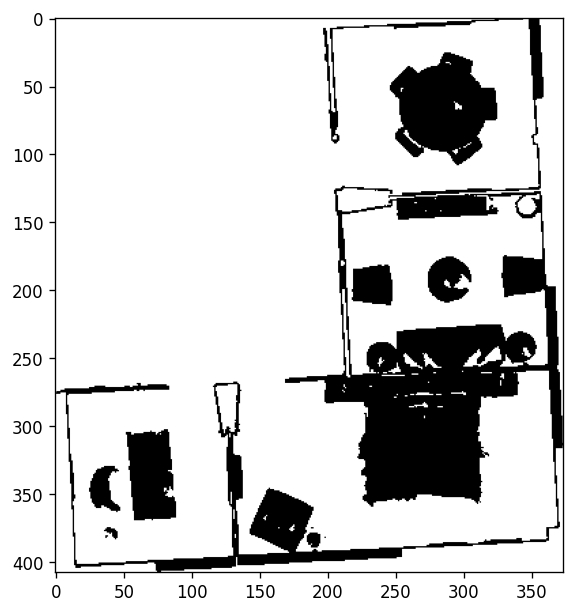

In [11]:
obstacles = load_map(obstacles_save_path)
# color_top_down = load_map(color_top_down_save_path)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()
np.save(os.path.join(map_save_dir, "obstacles_roomseg.npy"), obstacles[xmin:xmax+1, ymin:ymax+1])

In [12]:
import json
semantic_info_path = os.path.join(map_save_dir, f"semantic_info_lseg.json")
with open(semantic_info_path, "r", encoding="utf-8") as f:
    semantic_info = json.load(f)
print(type(semantic_info))
print(semantic_info)

<class 'list'>
['undefined', 'base-cabinet', 'basket', 'bathtub', 'bed', 'blinds', 'book', 'bottle', 'cabinet', 'chair', 'comforter', 'cup', 'cushion', 'curtain', 'ceiling', 'cooktop', 'countertop', 'desk', 'door', 'faucet', 'floor', 'handrail', 'indoor-plant', 'lamp', 'major-appliance', 'mat', 'nightstand', 'panel', 'picture', 'pillow', 'plant-stand', 'plate', 'pot', 'rack', 'refrigerator', 'shower-stall', 'sink', 'sofa', 'stair', 'stool', 'switch', 'table', 'toilet', 'vase', 'vent', 'wall', 'wall-cabinet', 'wall-plug', 'window', 'rug']


/tmp/ipykernel_1066763/906377448.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(semantic_info)).colors  # tab20 컬러맵을 사용하여 색상 생성


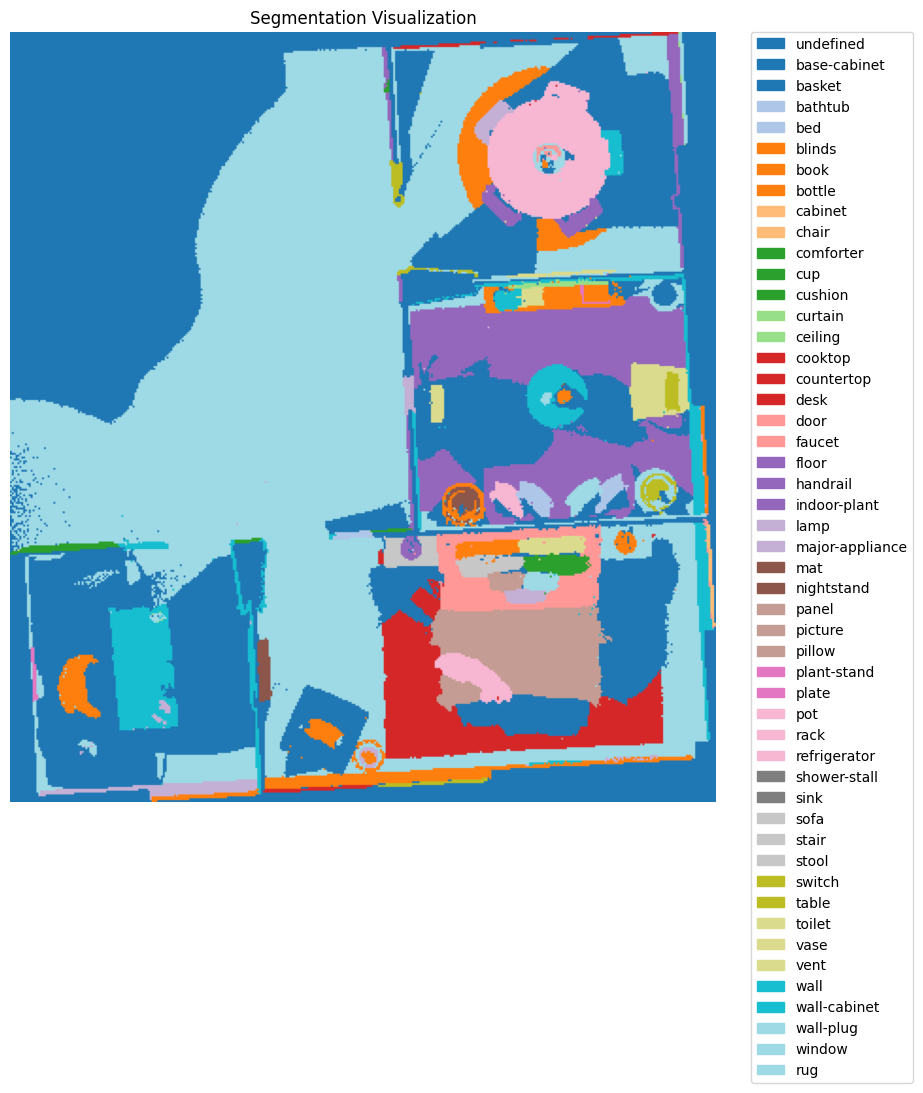

In [13]:

gt = load_map(gt_save_path)
gt = gt[xmin:xmax+1, ymin:ymax+1]
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# obj2cls_path = '/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/5LpN3gDmAk7_4/obj2cls_dict.txt'
# obj2cls = load_obj2cls_dict(obj2cls_path)

# gt = cvt_obj_id_2_cls_id(gt, obj2cls) #! here

colors = plt.cm.get_cmap('tab20', len(semantic_info)).colors  # tab20 컬러맵을 사용하여 색상 생성

segmentation_image = np.zeros((*gt.shape, 3), dtype=np.uint8)

for class_id, color in enumerate(colors):
    segmentation_image[gt == class_id] = np.array(color[:3]) * 255  # RGB 값으로 변환

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(segmentation_image)
plt.title("Segmentation Visualization")
plt.axis('off')

# 범주(legend)를 추가
patches = [mpatches.Patch(color=color, label=semantic_info[idx]) for idx, color in enumerate(colors)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()



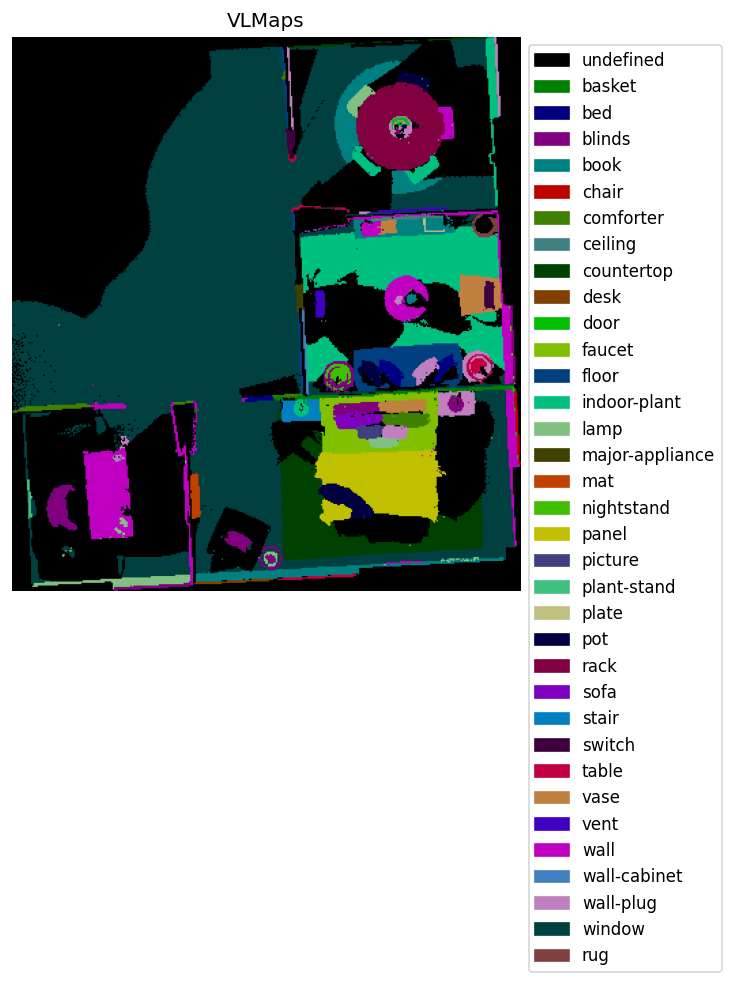

In [14]:

gt = load_map(gt_save_path)
gt = gt[xmin:xmax+1, ymin:ymax+1]

# print(gt)

# obj2cls_path = '/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/5LpN3gDmAk7_4/obj2cls_dict.txt'
# obj2cls = load_obj2cls_dict(obj2cls_path)

# gt = cvt_obj_id_2_cls_id(gt, obj2cls) #! here

no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
floor_mask = gt == 2
np.set_printoptions(threshold=np.inf)
new_pallete = get_new_pallete(len(semantic_info))
mask, patches = get_new_mask_pallete(gt, new_pallete, out_label_flag=True, labels=semantic_info)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

In [15]:
a='/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/5LpN3gDmAk7_4/obj2cls_dict.txt'


In [16]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from vlmaps.utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from vlmaps.utils.clip_utils import get_text_feats
from vlmaps.utils.matterport3d_categories import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip
import numpy as np
import matplotlib.pyplot as plt
from vlmaps.utils.matterport3d_categories import mp3dcat 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from vlmaps.utils.mapping_utils import cvt_obj_id_2_cls_id, load_obj2cls_dict

obj2cls_path = '/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/5LpN3gDmAk7_2/obj2cls_dict.txt'
obj2cls = load_obj2cls_dict(obj2cls_path)

# 예시 2D 배열

# data_path = '/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/SN83YJsR3w2_2/semantic/000018.npy'
# array_2d = np.load(data_path)
data_path = '/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/5LpN3gDmAk7_7/semantic/000090.npy'
array_2d = np.load(data_path)
# array_2d = np.loadtxt(data_path)
array_2d = array_2d.astype(int)
# data_path = '/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/hhhhhh.npy'
# array_2d = cvt_obj_id_2_cls_id(array_2d, obj2cls) #! here



print(array_2d.shape)

# # 2D 배열 시각화
# plt.imshow(array_2d, cmap='viridis')
# plt.colorbar()
# plt.title('2D Array Visualization')
# plt.show()
colors = plt.cm.get_cmap('tab20', len(mp3dcat)).colors  # tab20 컬러맵을 사용하여 색상 생성

segmentation_image = np.zeros((*array_2d.shape, 3), dtype=np.uint8)

for class_id, color in enumerate(colors):
    segmentation_image[array_2d == class_id] = np.array(color[:3]) * 255  # RGB 값으로 변환

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(segmentation_image)
plt.title("Segmentation Visualization")
plt.axis('off')

# 범주(legend)를 추가
patches = [mpatches.Patch(color=color, label=mp3dcat[idx]) for idx, color in enumerate(colors)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

print(array_2d)
np.set_printoptions(threshold=np.inf)
new_pallete = get_new_pallete(len(mp3dcat))
mask, patches = get_new_mask_pallete(array_2d, new_pallete, out_label_flag=True, labels=mp3dcat)
seg = mask.convert("RGBA")
seg = np.array(seg)
#seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

ModuleNotFoundError: No module named 'vlmaps'

In [ ]:
aa='/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/SN83YJsR3w2_1/semantic/000082.npy'
bb= '/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/SN83YJsR3w2_1/semantic/000010.npy'
a=np.load(aa)
b=np.load(bb)
c=a!=b
print(np.sum(c))

0


[0 1]


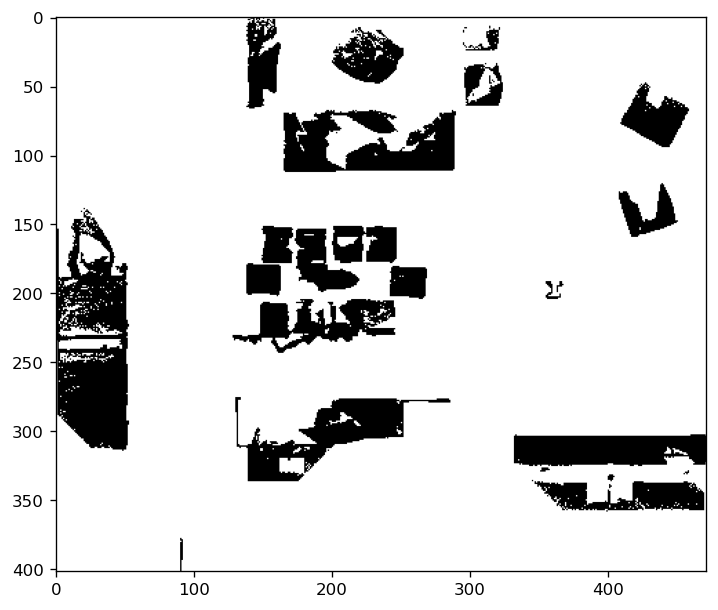

In [ ]:
gt_save_path = "/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/5LpN3gDmAk7_1/map_correct/grid_1_gt.npy"
obstacles = load_map(obstacles_save_path)
color_top_down = load_map(color_top_down_save_path)
x_indices, y_indices = np.where(obstacles == 0)


xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)


print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

/tmp/ipykernel_2264907/1330141145.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(mp3dcat)).colors  # tab20 컬러맵을 사용하여 색상 생성


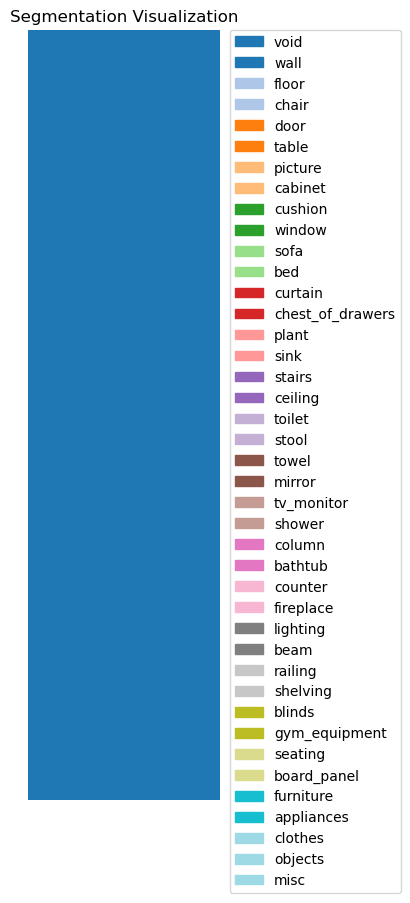

In [ ]:
gt = load_map(gt_save_path)
gt = gt[xmin:xmax+1, ymin:ymax+1]
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

colors = plt.cm.get_cmap('tab20', len(mp3dcat)).colors  # tab20 컬러맵을 사용하여 색상 생성

segmentation_image = np.zeros((*gt.shape, 3), dtype=np.uint8)

for class_id, color in enumerate(colors):
    segmentation_image[gt == class_id] = np.array(color[:3]) * 255  # RGB 값으로 변환

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(segmentation_image)
plt.title("Segmentation Visualization")
plt.axis('off')

# 범주(legend)를 추가
patches = [mpatches.Patch(color=color, label=mp3dcat[idx]) for idx, color in enumerate(colors)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

0


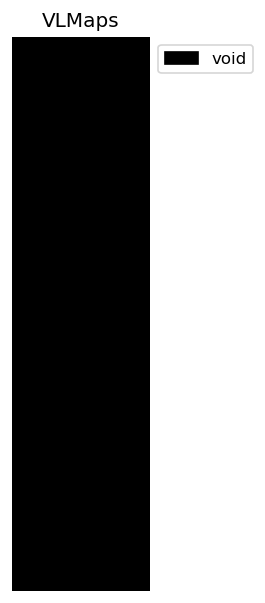

In [ ]:

no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
floor_mask = gt == 2

new_pallete = get_new_pallete(len(mp3dcat))
mask, patches = get_new_mask_pallete(gt, new_pallete, out_label_flag=True, labels=mp3dcat)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

you can see that the obstacles are black and the free space is white. You can also observe noisy black points lying on the ground. These points are caused by the slope or different floor heights in the scene.

## Show Top-Down Color Map

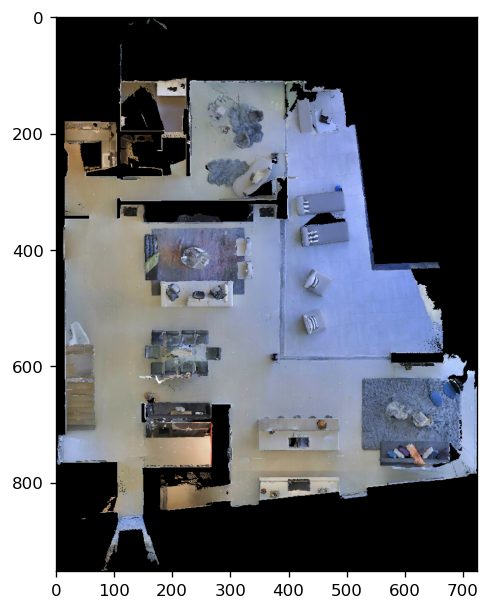

In [ ]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(color_top_down_pil)
plt.show()


the color map is created by projecting the color-augmented point cloud to the floor.

## Show Landmark Indexing Results

In [ ]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
clip_model.to(device).eval()

In [ ]:
grid = load_map(grid_save_path)
grid = grid[xmin:xmax+1, ymin:ymax+1]
print(grid_save_path)
# grid_save=np.reshape(grid,(1000000,512))
# #print(grid.shape)

# np.savetxt('custom_grid.txt', grid_save, fmt='%02.0f', delimiter=',')v
# #raise Exception("sfdsfsd")
# #grid = grid[xmin:xmax+1, ymin:ymax+1]
# grid_save[0]

/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/5LpN3gDmAk7_4/map/grid_lseg_lseg.npy


we use the text form of all semantic categories provided by the Matterport3D dataset as prompts to the VLMap and localize all categories in the map. We filter out "floor" category.

In [ ]:
# weight = load_map(weight_save_path)
# weight = weight[xmin:xmax+1, ymin:ymax+1]
# print(weight.shape)
# np.savetxt('data_weight.txt', weight, fmt='%3d', delimiter=',')

In [ ]:
# #obstacles=obstacles[xmin:xmax+1, ymin:ymax+1]
# print(obstacles.shape)
# np.savetxt('data_obstacles.txt', obstacles, fmt='%3d', delimiter=',')
# print(obstacles)

(953, 725)
<class 'numpy.ndarray'>
(41, 512)
(953, 725)
0
1
2
3
4
5
6
7
8
9
10
11
12
14
15
16
17
18
20
21
22
24
26
31
36
37
40


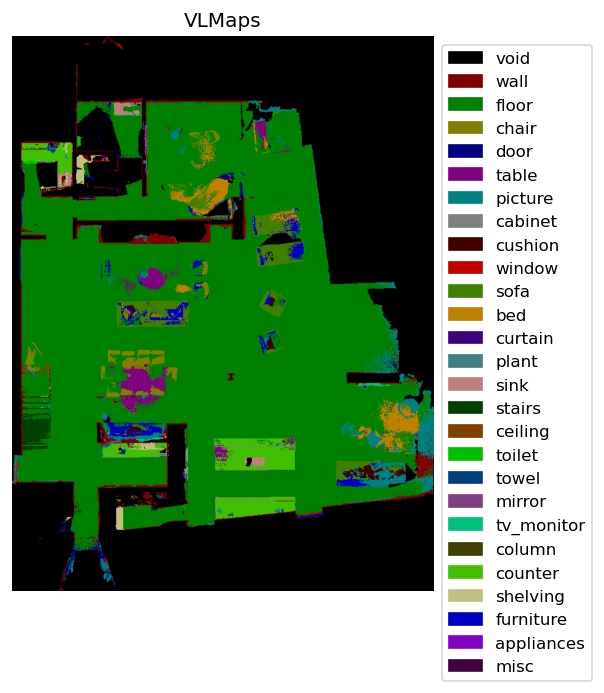

: 

In [ ]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
obstacles_rgb = np.repeat(obstacles[xmin:xmax+1, ymin:ymax+1, None], 3, axis=2)
print(no_map_mask.shape)

lang = mp3dcat 
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

print(type(text_feats))
print(text_feats.shape)

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2
print(predicts.shape)
new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
#seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

## Open-Vocabulary Landmark Indexing

In addition to using the fixed set of categories, we can also use customized text prompts to the map and index their corresponding locations. You could play around with the `lang` variable below by providing your own prompt. 

0
2
3
4
5


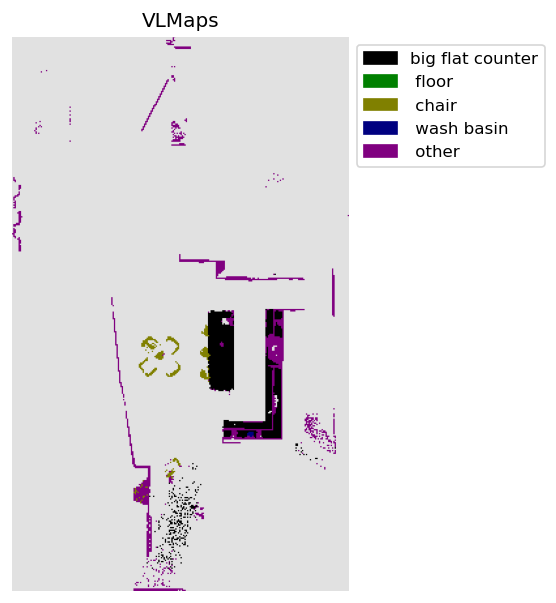

In [ ]:
# @markdown Input the prompt as a string of object names separated by ","
lang = "big flat counter, sofa, floor, chair, wash basin, other" # @param {type: "string"}
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

# 자연어 처리 부분

In [ ]:
#
#* LLM 처리 함수
import os
from openai import OpenAI

client = OpenAI(api_key=os.environ['OPENAI_KEY'])
openai_models=["gpt-3.5-turbo-instruct",
                "davinci-002",
                "text-embedding-3-large", # 못쓴다함
                "babbage-002",
                "gpt-4"]
openai_model=openai_models[0]

def parse_object_goal_instruction(language_instr):
    question = f"""
    I: go to the kitchen and then go to the toilet. A: kitchen, toilet
    I: go to the chair and then go to another chair. A: chair, chair
    I: navigate to the green sofa and turn right and find several chairs, finally go to the painting. A: green sofa, chairs, painting
    I: approach the window in front, turn right and go to the television, and finally go by the oven in the kitchen. A: window, television, oven, kitchen
    I: walk to the plant first, turn around and come back to the table, go further into the bedroom, and stand next to the bed. A: plant, table, bedroom, bed
    I: go by the stairs, go to the room next to it, approach the book shelf and then go to the table in the next room. A: stairs, room, book shelf, table, next room
    I: Go front left and move to the table, then turn around and find a cushion, later stand next to a column before finally navigate to any appliances. A: table, cushion, column, appliances.
    I: Move to the west of the chair, with the sofa on your right, move to the table, then turn right 90 degree, then find a table. A: chair, table
    I: {language_instr}. A:"""
    response = client.completions.create(model=openai_model, prompt=question, max_tokens=64, temperature=0.0)
    result = response.choices[0].text.strip()
    return [x.strip() for x in result.split(",")] #* 목표 키워드들의 리스트가 반환! spatial과는 다르게 키워드만 반환되고, 밖에서 target으로 이동시키는 함수에 해당 키워드가 들어가 이동


# 로봇 navigation 테스트

## 세팅

In [ ]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from vlmaps.utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from vlmaps.utils.clip_utils import get_text_feats
from vlmaps.utils.mp3dcat import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, "map")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_1.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_lseg_1.npy")
obstacles_save_path = os.path.join(map_save_dir, "obstacles.npy")
weight_save_path = os.path.join(map_save_dir, f"weight_lseg_1.npy")
print(data_dir)


/home/hong/capstone/vlmaps/data_demo/UwV83HsGsw3_1


In [ ]:
obstacles = load_map(obstacles_save_path)
color_top_down = load_map(color_top_down_save_path)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles=obstacles[xmin:xmax+1, ymin:ymax+1]
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]

[0 1]


In [ ]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
clip_model.to(device).eval()

In [ ]:
grid = load_map(grid_save_path)
grid = grid[xmin:xmax+1, ymin:ymax+1]
print(grid_save_path)
# grid_save=np.reshape(grid,(1000000,512))
# #print(grid.shape)

# np.savetxt('custom_grid.txt', grid_save, fmt='%02.0f', delimiter=',')
# #raise Exception("sfdsfsd")
# #grid = grid[xmin:xmax+1, ymin:ymax+1]
# grid_save[0]

/home/hong/capstone/vlmaps/data_demo/UwV83HsGsw3_1/map/grid_lseg_1.npy


In [ ]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
obstacles_rgb = np.repeat(obstacles[xmin:xmax+1, ymin:ymax+1, None], 3, axis=2)
print(no_map_mask.shape)

lang = mp3dcat 
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2
print(predicts.shape)

(435, 102)
(576, 504)


##  자연어 이동 명령

In [ ]:
instruction="Go to the closest cushion first, then go to a chair nearby, after that, go to a counter and in the end, navigate to a table."
object_categories = parse_object_goal_instruction(instruction)
print(object_categories)

['cushion', 'chair', 'counter', 'table']


## 로봇 초기 위치 랜덤 설정 (테스트용, 제거 필요)

In [ ]:
from copy import deepcopy
import random
print(floor_mask.shape)
robot_mask=deepcopy(floor_mask)
while True:
    rand_x=random.randint(0, robot_mask.shape[0]-1)
    rand_y=random.randint(0, robot_mask.shape[1]-1)
    if robot_mask[rand_x, rand_y]:
        robot_mask[:]=False
        robot_mask[rand_x, rand_y]=True
        break
robot_point=[rand_x,rand_y]
print(robot_mask[robot_point[0],robot_point[1]])
print(predicts[robot_mask])
print(robot_point)

(576, 504)
True
[2]
[496, 140]


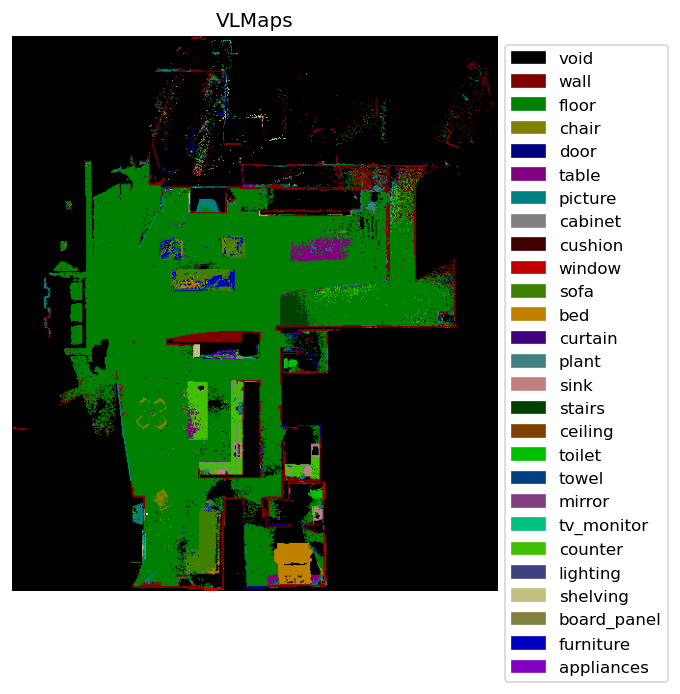

In [ ]:
new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
#seg[no_map_mask] = [225, 225, 225, 255]
#seg[floor_mask] = [225, 225, 225, 255]
#seg[rand_x,rand_y]=[225, 225, 225, 255]
seg[rand_x-1:rand_x+1, rand_y-1:rand_y+1] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

In [ ]:
from typing import List, Tuple, Any
from scipy.ndimage import binary_closing, binary_dilation, gaussian_filter

def get_segment_islands_pos(segment_map, label_id, detect_internal_contours=False):


    mask = segment_map == label_id #* 맵에서 label_id 즉, 1값이 있는 곳만 찾아 mask를 만듦
    mask = mask.astype(np.uint8)
    detect_type = cv2.RETR_EXTERNAL
    if detect_internal_contours:
        detect_type = cv2.RETR_TREE

    contours, hierarchy = cv2.findContours(mask, detect_type, cv2.CHAIN_APPROX_SIMPLE)
    # convert contours back to numpy index order
    contours_list = []
    for contour in contours:
        tmp = contour.reshape((-1, 2))
        tmp_1 = np.stack([tmp[:, 1], tmp[:, 0]], axis=1)
        contours_list.append(tmp_1)

    centers_list = []
    bbox_list = []
    for c in contours_list:
        xmin = np.min(c[:, 0])
        xmax = np.max(c[:, 0])
        ymin = np.min(c[:, 1])
        ymax = np.max(c[:, 1])
        bbox_list.append([xmin, xmax, ymin, ymax])

        centers_list.append([(xmin + xmax) / 2, (ymin + ymax) / 2])


    import matplotlib.pyplot as plt
    from PIL import Image  
    hong_vis = Image.fromarray(mask)
    plt.figure(figsize=(8, 6), dpi=120)
    plt.imshow(hong_vis, cmap='gray')  
    plt.show()



    return contours_list, centers_list, bbox_list, hierarchy




def get_pos(predicts, name: str,idx) -> Tuple[List[List[int]], List[List[float]], List[np.ndarray], Any]:
    """
    Get the contours, centers, and bbox list of a certain category
    on a full map
    """
    # cat_id = find_similar_category_id(name, self.categories)
    # labeled_map_cropped = self.scores_mat.copy()  # (N, C) N: number of voxels, C: number of categories
    # labeled_map_cropped = np.argmax(labeled_map_cropped, axis=1)  # (N,)
    # pc_mask = labeled_map_cropped == cat_id # (N,)
    # self.grid_pos[pc_mask]

    table_mask = predicts == idx
    # print(table_mask)
    #* 아래의 foreground 작업은 noise 및 작은 친구들을 제거해주는 작업임
    foreground = binary_closing(table_mask, iterations=3) #* 작은 구멍을 메우는 작업이라는데?
    foreground = gaussian_filter(foreground.astype(float), sigma=0.8, truncate=3)
    foreground = foreground > 0.5
    # cv2.imshow(f"mask_{name}_gaussian", (foreground * 255).astype(np.uint8))
    foreground = binary_dilation(foreground)
    # print(foreground)
    # print(foreground.shape) #* mask_2d와 같은 shape


    import matplotlib.pyplot as plt
    from PIL import Image  
    obstacles_pil = Image.fromarray(foreground)
    plt.figure(figsize=(8, 6), dpi=120)
    plt.imshow(obstacles_pil, cmap='gray')  
    plt.show()
    
    #raise Exception("Sfdsfsdfsdfsdf")

    
    # cv2.imshow(f"mask_{name}_processed", (foreground.astype(np.float32) * 255).astype(np.uint8))
    # cv2.waitKey()
    #* ex. (1,1) 길이 4짜리 정사각형 -> contour: [−1.0,−1.0],[3.0,−1.0],[3.0,3.0],[−1.0,3.0] / bb : [-1,-1,3,3]
    contours, centers, bbox_list, _ = get_segment_islands_pos(foreground, 1) #* 1은 label_id인데, 장애물이 있는 위치를 나타내는게 1이니깐 이걸 넣어준 거 즉, 장애물이 있는 곳에 대한 아웃풋들을 구하겠다
    # print("centers", centers)

    # whole map position
    # #* crop된 맵을 기준으로 좌표를 구했으니 옆쪽의 잘린 길이들을 더해줘서 crop뙤지 않은 맵을 기준의 좌표로 변환해줌
    # for i in range(len(contours)):
    #     centers[i][0] += self.rmin
    #     centers[i][1] += self.cmin
    #     bbox_list[i][0] += self.rmin
    #     bbox_list[i][1] += self.rmin
    #     bbox_list[i][2] += self.cmin
    #     bbox_list[i][3] += self.cmin
    #     for j in range(len(contours[i])):
    #         contours[i][j, 0] += self.rmin
    #         contours[i][j, 1] += self.cmin
    #* 리턴되는 것은 그 id의 모든 island들의 contour, center, bbox의 리스트
    return contours, centers, bbox_list
#contours,centers,bbox_list = get_pos(predicts,"sdfdsfsf",5)


NameError: name 'np' is not defined

In [ ]:
from copy import deepcopy
import random
print(floor_mask.shape)
robot_mask=deepcopy(floor_mask)
while True:
    rand_x=random.randint(0, robot_mask.shape[0]-1)
    rand_y=random.randint(0, robot_mask.shape[1]-1)
    if robot_mask[rand_x, rand_y]:
        robot_mask[:]=False
        robot_mask[rand_x, rand_y]=True
        break
robot_point=[rand_x,rand_y]
print(robot_mask[robot_point[0],robot_point[1]])
print(predicts[robot_mask])

(576, 504)
True
[2]


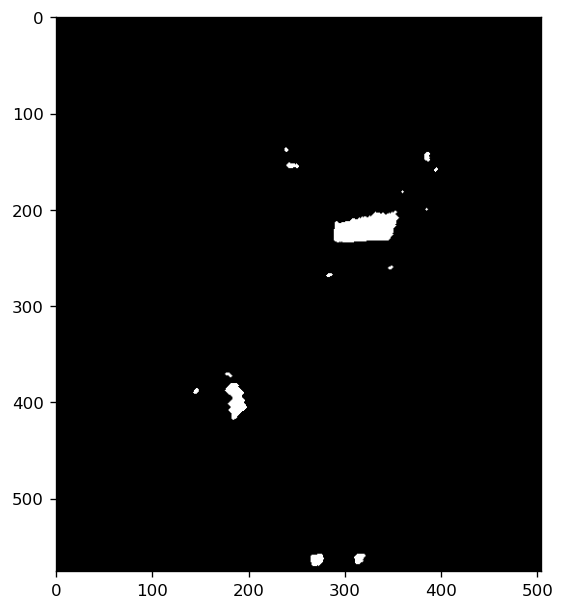

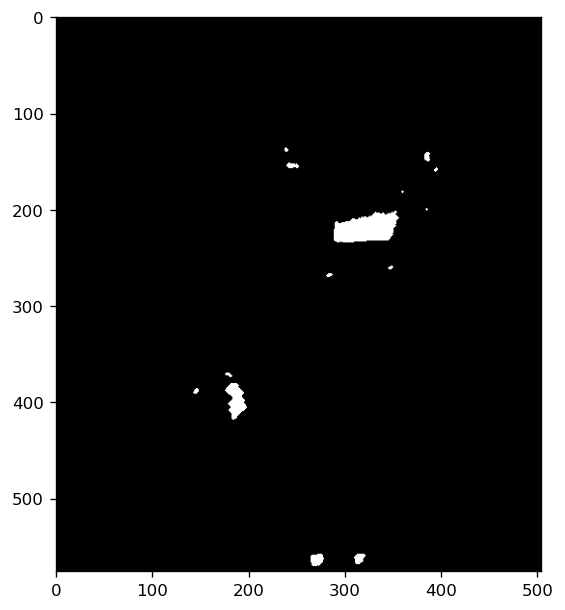

before filtering
14
10 11 110
12 13 156
5 5 25
37 22 814
4 7 28
3 6 18
3 5 15
32 67 2144
2 2 4
2 2 4
4 3 12
5 12 60
9 5 45
4 3 12
after filtering
4
4
4


In [ ]:
from shapely.geometry import Point, Polygon

def filter_small_objects(bbox_list: List[List[int]], area_thres: int = 50) -> List[int]:
    results_ids = []
    print("before filtering")
    print(len(bbox_list))
    for bbox_i, bbox in enumerate(bbox_list):
        dx = bbox[1] - bbox[0]
        dy = bbox[3] - bbox[2]
        area = dx * dy
        print(dx,dy,area)
        if area > area_thres:
            results_ids.append(bbox_i)
    print("after filtering")
    print(len(results_ids))
    return results_ids


def select_nearest_obj(
    centers: List[List[float]],
    bbox_list: List[List[float]],
    curr_pos: Tuple[float, float],
) -> int:
    dist_list = []
    print(len(bbox_list))
    for c, bbox in zip(centers, bbox_list):
        size = np.array([bbox[1] - bbox[0], bbox[3] - bbox[2]])
        dist = get_dist_to_bbox_2d(np.array(c), size, np.array(curr_pos)) #* 각 island 별 장애물과 로봇 사이 거리 구함
        dist_list.append(dist) #* 이걸 리스트에 넣어줌
    print(len(dist_list))
    id = np.argmin(dist_list) #* 그중에서 가장 작은 값을 갖는 녀석의 인덱스 번호를 획득
    return id #* 해당 인덱스 번호를 반환



def nearest_point_on_polygon(coord: List[float], polygon: List[List[float]]):
    # Create a Shapely Point from the given coordinate
    point = Point(coord) #* shapely.geometry.Point 객체 생성 -> 기하 관련 패키지인듯

    # Create a Shapely Polygon from the polygon's coordinates
    poly = Polygon(polygon) #* shapely.geometry.Polygon 객체 생성

    # Find the nearest point on the polygon's boundary to the given point
    nearest = poly.exterior.interpolate(poly.exterior.project(point))

    # Extract the nearest point's coordinates as a tuple
    nearest_coords = [int(nearest.x), int(nearest.y)]

    return nearest_coords


def get_bbox(center, size):
    """
    Return min corner and max corner coordinate
    """
    min_corner = center - size / 2
    max_corner = center + size / 2
    return min_corner, max_corner





def get_dist_to_bbox_2d(center, size, pos):
    min_corner_2d, max_corner_2d = get_bbox(center, size)

    dx = pos[0] - center[0]
    dy = pos[1] - center[1]

    if pos[0] < min_corner_2d[0] or pos[0] > max_corner_2d[0]:
        if pos[1] < min_corner_2d[1] or pos[1] > max_corner_2d[1]:
            #* 이경우엔 북서, 북동, 남서, 남동에 위치하고 장애물 밖에 로봇이 위치한 경우
            #* 그냥 피타고라스 거리
            """
            star region
            *  |  |  *
            ___|__|___
               |  |
            ___|__|___
               |  |
            *  |  |  *
            """

            dx_c = np.abs(dx) - size[0] / 2
            dy_c = np.abs(dy) - size[1] / 2
            dist = np.sqrt(dx_c * dx_c + dy_c * dy_c)
            return dist
        else:
            #* 이 경우엔 서, 동에 위치한 경우
            #* 장애물 중심으로부터의 가로 거리를 구하고 여기서 장애물 가로 길이의 반을 빼줌
            """
            star region
               |  |
            ___|__|___
            *  |  |  *
            ___|__|___
               |  |
               |  |
            """
            dx_b = np.abs(dx) - size[0] / 2
            return dx_b
    else:
        if pos[1] < min_corner_2d[1] or pos[1] > max_corner_2d[1]:
            #* 이 경우엔 북, 남에 위치한 경우
            #* 장애물 중심으로부터 세로 거리를 구하고 여기서 장애물 세로 길이의 반을 빼줌
            """
            star region
               |* |
            ___|__|___
               |  |
            ___|__|___
               |* |
               |  |
            """
            dy_b = np.abs(dy) - size[1] / 2
            return dy_b
        #* 그 외에는 장애물 내부에 위치한 것이니 그냥 0을 반환
        """
        star region
           |  |  
        ___|__|___
           |* |   
        ___|__|___
           |  |   
           |  |  
        """
        return 0
    



def get_nearest_pos(predicts, curr_pos: List[float], name: str,idx) -> List[float]:
    contours, centers, bbox_list = get_pos(predicts,name,idx) #* 지금 map_config.yaml에서 맵 타입이 vlmaps로 지정되어서 Map을 부모 클래스로 하는 VLMap을 사용하는 상태!, 따라서 get_pos는 VLMap에 정의되어있으므로 그걸 사용
    #* 해당 island에 해당되는 모든 island의 해당 정보 반환
    ids_list = filter_small_objects(bbox_list, area_thres=100) #* bbox가 지나치게 작은 경우 노이즈일 경우가 높으므로 해당 island들은 필터링하기 위해 그 인덱스들의 리스트 획득
    contours = [contours[i] for i in ids_list] #* 이를 이용해 작은 친구들(노이즈)는 필터링
    centers = [centers[i] for i in ids_list]
    bbox_list = [bbox_list[i] for i in ids_list]
    if len(centers) == 0:
        print("warning")
        return curr_pos #* 만약 해당 id에 해당되는 친구가 없다면 현재 위치를 반환
    id = select_nearest_obj(centers, bbox_list, curr_pos) #* 그렇지않다면 현재 위치에서 가장 가까운 친구의 인덱스를 획득

    return nearest_point_on_polygon(curr_pos, contours[id]) #* 해당 island의 경계선 중에서 현재 로봇 위치와 가장 가까운 지점의 좌표를 획득해 반환하는 것

coo = get_nearest_pos(predicts,robot_point,"sdfdsfsf",5)

In [ ]:
print(coo)

[214, 289]


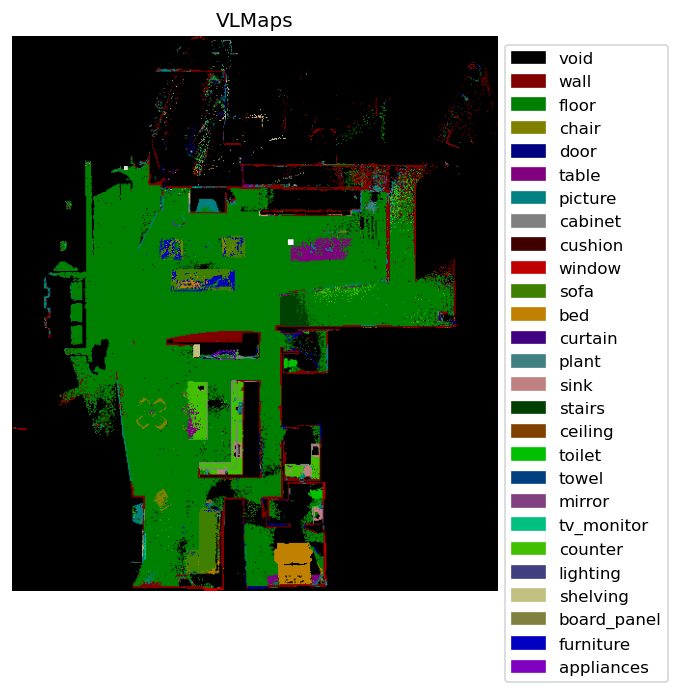

In [ ]:
coo_x=coo[0]
coo_y=coo[1]

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
#seg[no_map_mask] = [225, 225, 225, 255]
#seg[floor_mask] = [225, 225, 225, 255]
#seg[rand_x,rand_y]=[225, 225, 225, 255]
seg[rand_x-2:rand_x+2, rand_y-2:rand_y+2] = [225, 225, 225, 255]
seg[coo_x-3:coo_x+3, coo_y-3:coo_y+3] = [0,0,0, 0]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

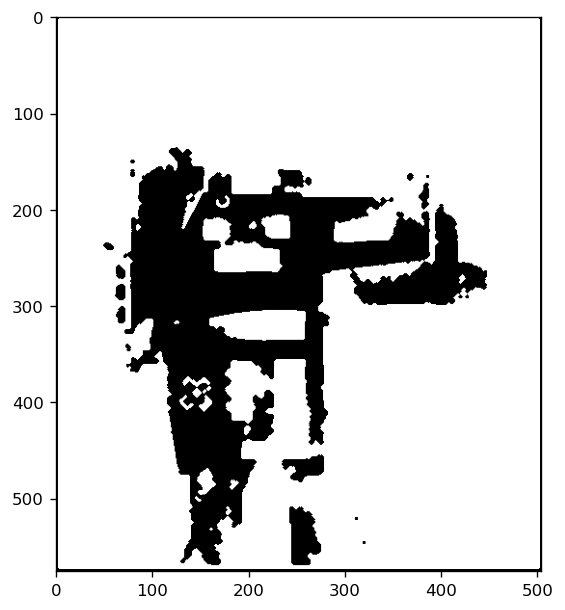

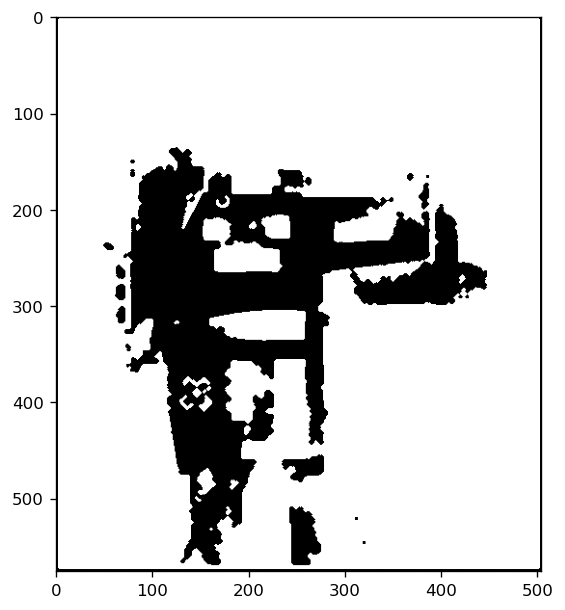

In [ ]:
def get_pos_nav(predicts, name: str,use_internal_contour=False) -> Tuple[List[List[int]], List[List[float]], List[np.ndarray], Any]:
    """
    Get the contours, centers, and bbox list of a certain category
    on a full map
    """
    # cat_id = find_similar_category_id(name, self.categories)
    # labeled_map_cropped = self.scores_mat.copy()  # (N, C) N: number of voxels, C: number of categories
    # labeled_map_cropped = np.argmax(labeled_map_cropped, axis=1)  # (N,)
    # pc_mask = labeled_map_cropped == cat_id # (N,)
    # self.grid_pos[pc_mask]

    nav_mask = (predicts != 2)# & (predicts != 2)
    # print(nav_mask)
    #* 아래의 foreground 작업은 noise 및 작은 친구들을 제거해주는 작업임
    foreground = binary_closing(nav_mask, iterations=3) #* 작은 구멍을 메우는 작업이라는데?
    foreground = gaussian_filter(foreground.astype(float), sigma=0.8, truncate=3)
    foreground = foreground > 0.5
    # cv2.imshow(f"mask_{name}_gaussian", (foreground * 255).astype(np.uint8))
    foreground = binary_dilation(foreground)
    # print(foreground)
    # print(foreground.shape) #* mask_2d와 같은 shape


    import matplotlib.pyplot as plt
    from PIL import Image  
    obstacles_pil = Image.fromarray(foreground)
    plt.figure(figsize=(8, 6), dpi=120)
    plt.imshow(obstacles_pil, cmap='gray')  
    plt.show()
#    raise Exception("sdfsdfd")
    #raise Exception("Sfdsfsdfsdfsdf")

    
    # cv2.imshow(f"mask_{name}_processed", (foreground.astype(np.float32) * 255).astype(np.uint8))
    # cv2.waitKey()
    #* ex. (1,1) 길이 4짜리 정사각형 -> contour: [−1.0,−1.0],[3.0,−1.0],[3.0,3.0],[−1.0,3.0] / bb : [-1,-1,3,3]
    #contours, centers, bbox_list, _ = get_segment_islands_pos(foreground, 1)
    contours, centers, bbox_list, hierarchy = get_segment_islands_pos(
        foreground, 1, detect_internal_contours=True#use_internal_contour
    )
    # print("centers", centers)

    # whole map position
    # #* crop된 맵을 기준으로 좌표를 구했으니 옆쪽의 잘린 길이들을 더해줘서 crop뙤지 않은 맵을 기준의 좌표로 변환해줌
    # for i in range(len(contours)):
    #     centers[i][0] += self.rmin
    #     centers[i][1] += self.cmin
    #     bbox_list[i][0] += self.rmin
    #     bbox_list[i][1] += self.rmin
    #     bbox_list[i][2] += self.cmin
    #     bbox_list[i][3] += self.cmin
    #     for j in range(len(contours[i])):
    #         contours[i][j, 0] += self.rmin
    #         contours[i][j, 1] += self.cmin
    #* 리턴되는 것은 그 id의 모든 island들의 contour, center, bbox의 리스트
    return contours, centers, bbox_list
a,b,c=get_pos_nav(predicts,"sdfdsfsf")

In [ ]:
def build_visgraph_with_obs_map(obs_map, use_internal_contour=False, internal_point=None, vis=False):
    obs_map_vis = (obs_map[:, :, None] * 255).astype(np.uint8)
    obs_map_vis = np.tile(obs_map_vis, [1, 1, 3])
    print(obs_map_vis.shape)
    if vis:
        cv2.imshow("obs", obs_map_vis)
        cv2.waitKey()
    contours, centers, bbox_list = get_pos_nav(predicts,"sdfdsfsf")
    print(len(contours),len(centers),len(bbox_list))
    ids_list = filter_small_objects(bbox_list, area_thres=100) #* bbox가 지나치게 작은 경우 노이즈일 경우가 높으므로 해당 island들은 필터링하기 위해 그 인덱스들의 리스트 획득
    contours = [contours[i] for i in ids_list] #* 이를 이용해 작은 친구들(노이즈)는 필터링
    centers = [centers[i] for i in ids_list]
    bbox_list = [bbox_list[i] for i in ids_list]



    print(centers)
#    raise Exception("sdfsdf")
    #seg[rand_x-2:rand_x+2, rand_y-2:rand_y+2] = [225, 225, 225, 255]
    #seg[coo_x-3:coo_x+3, coo_y-3:coo_y+3] = [0,0,0, 0]


    #print(len(contours_list)) 

    poly_list = []

    for contour in contours:
        if vis:
            contour_cv2 = contour[:, [1, 0]]
            cv2.drawContours(obs_map_vis, [contour_cv2], 0, (0, 255, 0), 3)
            cv2.imshow("obs", obs_map_vis)
        contour_pos = []
        for [row, col] in contour:
            contour_pos.append(vg.Point(row, col))
        poly_list.append(contour_pos)
        xlist = [x.x for x in contour_pos]
        zlist = [x.y for x in contour_pos]
        if vis:
            # plt.plot(xlist, zlist)
            cv2.waitKey()
    print(len(poly_list))
    print(poly_list[0])
    for i in range(len(poly_list)):
        print(len(poly_list[i]))
    #raise Exception("sdfsdf")  
    g = vg.VisGraph()
    g.build(poly_list)#, workers=4) #! 에러 발생
    return g


(576, 504)
(576, 504, 3)


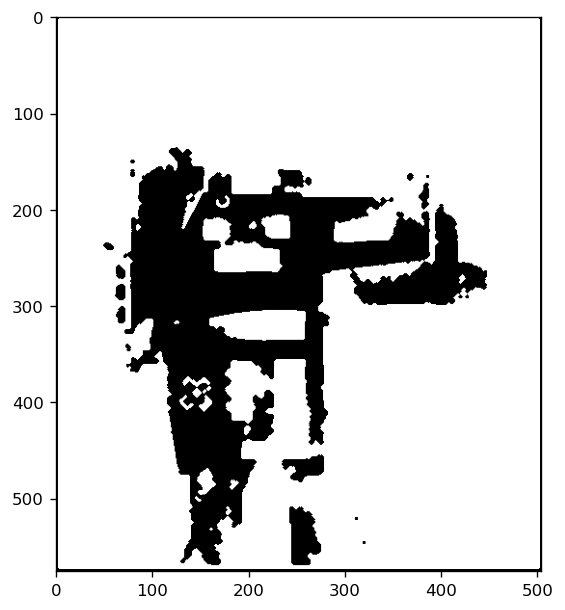

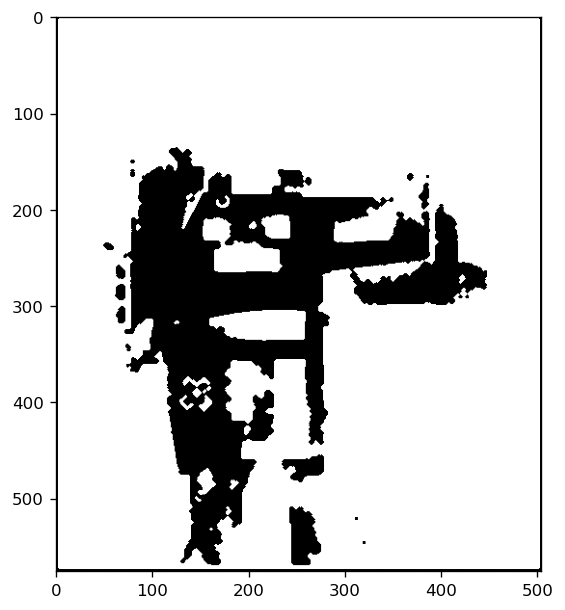

38 38 38
before filtering
38
571 499 284929
4 4 16
4 4 16
62 34 2108
30 45 1350
9 7 63
19 11 209
5 5 25
5 6 30
18 12 216
16 11 176
9 12 108
29 12 348
4 4 16
9 8 72
9 6 54
5 6 30
435 378 164430
2 3 6
8 5 40
5 6 30
10 9 90
27 19 513
9 6 54
17 13 221
15 14 210
9 9 81
7 8 56
10 28 280
3 5 15
31 99 3069
9 6 54
6 4 24
7 7 49
56 82 4592
24 29 696
12 13 156
6 6 36
after filtering
17
[[287.5, 251.5], [539.0, 258.0], [469.0, 255.5], [309.5, 66.5], [286.0, 66.0], [265.0, 66.5], [238.5, 54.0], [186.5, 381.0], [352.5, 258.0], [482.5, 155.5], [401.5, 154.5], [400.5, 135.0], [379.0, 145.0], [320.5, 208.5], [237.0, 193.0], [218.0, 227.5], [192.0, 172.5]]


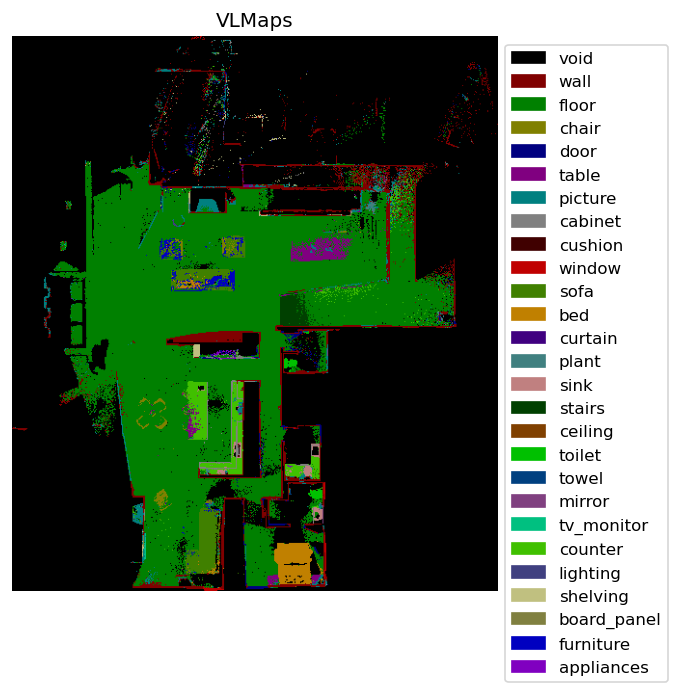

17
[Point(2.00, 3.00), Point(3.00, 2.00), Point(572.00, 2.00), Point(573.00, 3.00), Point(573.00, 500.00), Point(572.00, 501.00), Point(3.00, 501.00), Point(2.00, 500.00)]
8
47
50
14
12
12
10
23
1032
40
13
19
29
50
78
30
24


  0%|          | 0/150 [00:00<?, ?it/s]


UnboundLocalError: local variable 'same_point' referenced before assignment

In [ ]:
# graph = vg.VisGraph()
# graph.build(obstacles)
print(obstacles.shape)
graph = build_visgraph_with_obs_map(obstacles)

In [ ]:
import pyvisgraph as vg
b = (predicts != 0) & (predicts != 2)
print(b.shape)
print(b)
print(predicts.shape)

(576, 504)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(576, 504)


In [ ]:
start=vg.Point(robot_point[0],robot_point[1])
goal=vg.Point(coo[0],coo[1])
path = graph.shortest_path(start, goal)
print(len(path),path)

NameError: name 'graph' is not defined

(576, 504) (576, 504)


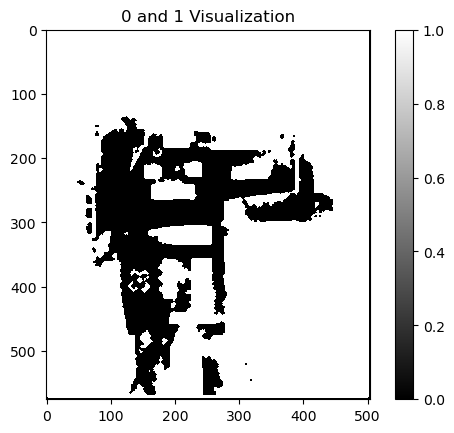

In [ ]:
def get_2(predicts, name: str,use_internal_contour=False) -> Tuple[List[List[int]], List[List[float]], List[np.ndarray], Any]:
    """
    Get the contours, centers, and bbox list of a certain category
    on a full map
    """
    # cat_id = find_similar_category_id(name, self.categories)
    # labeled_map_cropped = self.scores_mat.copy()  # (N, C) N: number of voxels, C: number of categories
    # labeled_map_cropped = np.argmax(labeled_map_cropped, axis=1)  # (N,)
    # pc_mask = labeled_map_cropped == cat_id # (N,)
    # self.grid_pos[pc_mask]

    nav_mask = (predicts != 2)# & (predicts != 2)
    # print(nav_mask)
    #* 아래의 foreground 작업은 noise 및 작은 친구들을 제거해주는 작업임
    foreground = binary_closing(nav_mask, iterations=3) #* 작은 구멍을 메우는 작업이라는데?
    foreground = gaussian_filter(foreground.astype(float), sigma=0.8, truncate=3)
    foreground = foreground > 0.5
    # cv2.imshow(f"mask_{name}_gaussian", (foreground * 255).astype(np.uint8))
    foreground = binary_dilation(foreground)
    return foreground
a=get_2(predicts,"sdfdsfsf")
b=a.astype(int)
print(a.shape, b.shape)
#raise Exception("Sfsdf")
import matplotlib.pyplot as plt
# 배열 시각화
plt.imshow(b, cmap='gray', interpolation='nearest')
plt.colorbar()  # 색상 막대 추가
plt.title('0 and 1 Visualization')
plt.show()

In [ ]:
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder

# 격자 생성
grid = Grid(matrix=b, inverse=True)
print(grid)
print(robot_point,coo)
# 시작점과 종점 정의

<Grid width=504 height=576>
[137, 118] [214, 289]


In [ ]:
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder

# 격자 생성
grid = Grid(matrix=b, inverse=True)
print(grid)
print(robot_point,coo)
# 시작점과 종점 정의
#*y,x반전!!
#start=grid.node(269,254)
#end=grid.node(271,254)
start = grid.node(robot_point[1], robot_point[0])  # 시작점: (0,0)
#end = grid.node(coo[1], coo[0])    # 종점: (4,8)
end = grid.node(coo[1]-5, coo[0]-5)    # 종점: (4,8)
print(start,end)
#raise Exception("sdfsdfsdf")
# A* 경로 찾기 객체 생성
finder = AStarFinder(diagonal_movement=DiagonalMovement.never)

# 경로 찾기
path, runs = finder.find_path(start, end, grid)

print("Operations used:", runs)
print("Path:", path)
#print(grid.grid_str(path=path, start=start, end=end))


<Grid width=504 height=576>
[137, 118] [214, 289]
<GridNode(118:137 0x764be8e6c550)> <GridNode(284:209 0x764be83a04f0)>
Operations used: 547
Path: [<GridNode(118:137 0x764be8e6c550)>, <GridNode(119:137 0x764be8e6c580)>, <GridNode(120:137 0x764be8e6c5b0)>, <GridNode(121:137 0x764be8e6c5e0)>, <GridNode(122:137 0x764be8e6c610)>, <GridNode(123:137 0x764be8e6c640)>, <GridNode(124:137 0x764be8e6c670)>, <GridNode(125:137 0x764be8e6c6a0)>, <GridNode(126:137 0x764be8e6c6d0)>, <GridNode(126:138 0x764be8e126d0)>, <GridNode(127:138 0x764be8e12700)>, <GridNode(127:139 0x764be8e38700)>, <GridNode(128:139 0x764be8e38730)>, <GridNode(128:140 0x764be8dde730)>, <GridNode(129:140 0x764be8dde760)>, <GridNode(129:141 0x764be8d84760)>, <GridNode(130:141 0x764be8d84790)>, <GridNode(130:142 0x764be8daa790)>, <GridNode(131:142 0x764be8daa7c0)>, <GridNode(132:142 0x764be8daa7f0)>, <GridNode(133:142 0x764be8daa820)>, <GridNode(134:142 0x764be8daa850)>, <GridNode(135:142 0x764be8daa880)>, <GridNode(136:142 0x764b

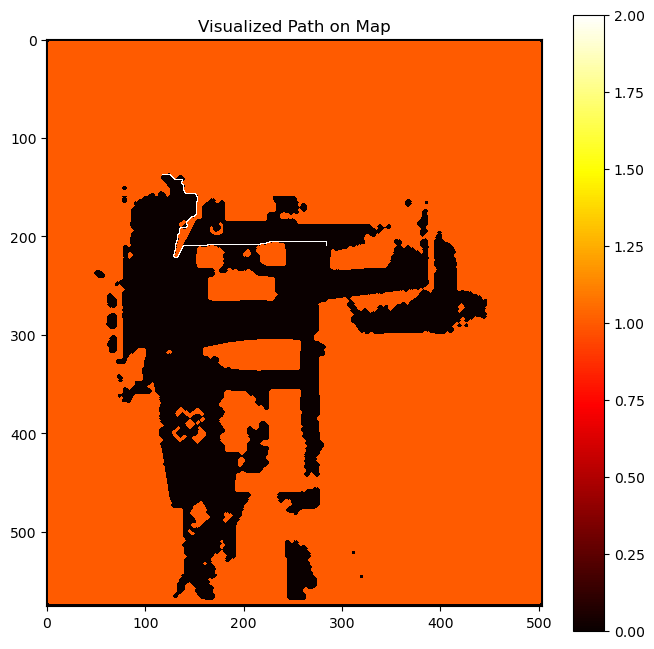

In [ ]:
for point in path:
    b[point.y, point.x] = 2  # 경로를 '2'로 표시
# 시각화
plt.figure(figsize=(8, 8))
plt.imshow(b, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Visualized Path on Map')
plt.show()

In [ ]:
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
a=np.array([[0,1,1,1,1,1,1,0],[1,0,0,0,0,0,0,1]])
grid = Grid(matrix=a)
start = grid.node(1,0)
end = grid.node(6,0)
finder = AStarFinder(diagonal_movement=DiagonalMovement.never)
path, runs = finder.find_path(start, end, grid)
print('operations:', runs, 'path length:', len(path))
print(path)

operations: 6 path length: 6
[<GridNode(1:0 0x764e354515b0)>, <GridNode(2:0 0x764e35451040)>, <GridNode(3:0 0x764e35451760)>, <GridNode(4:0 0x764e35451400)>, <GridNode(5:0 0x764e354514c0)>, <GridNode(6:0 0x764e35451d60)>]
